In [26]:
# (0) 関数の定義、config
from scipy.special import erf, erfinv
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import pandas as pd
from mpmath import erfinv, mp

##　読み込みファイルの指定
hold_file = "csv_files/hold_time.csv"
setup_file = "csv_files/setup_time.csv"
jitter_file = "csv_files/jitter.csv"
power_file = "csv_files/power.csv"

def mp_to_float_exact(mp):
    mp_str = str(mp)
    j = 2
    for i in range(3, len(mp_str)):
        if mp_str[i] == '0':
            j += 1
        else:
            break
    return j

def calc_error(t,setup,hold,total):
    return 1-erf((t-setup-hold)/(2*total*2**(1/2)))

def calc_error_mp(t,setup,hold,total):
    mp.dps = 1000
    t = mp.mpf(t)
    setup = mp.mpf(setup)
    hold = mp.mpf(hold)
    total = mp.mpf(total)
    return 1-mp.erf((t-setup-hold)/(2*total*2**(1/2)))

def calc_total(j_setup,j_hold,jitter,bai):
    return (bai*(jitter**2) + j_setup**2 + j_hold**2)**(1/2)

def calc_total_mp(j_setup,j_hold,jitter,bai):
    mp.dps = 1000
    j_setup = mp.mpf(j_setup)
    j_hold = mp.mpf(j_hold)
    jitter = mp.mpf(jitter)
    bai = mp.mpf(bai)
    return (bai*(jitter**2) + (1*j_setup)**2 + (1*j_hold)**2)**(1/2)

def calc_t(error, setup, hold, total):
    if error <= 0 or error >= 1:
        raise ValueError("error must be between 0 and 1 (exclusive).")

    mp.dps = 1000
    error = mp.mpf(error)
    setup = mp.mpf(setup)
    hold = mp.mpf(hold)
    total = mp.mpf(total)
    adjusted_error = mp.mpf(1) - error
    t = setup + hold + 2 * total * (2**0.5) * erfinv(adjusted_error)
    #return float(t)  # 必要に応じてfloatに変換

    # 逆誤差関数を使って t を計算
    return setup + hold + 2 * total * (2**0.5) * erfinv(1 - error)

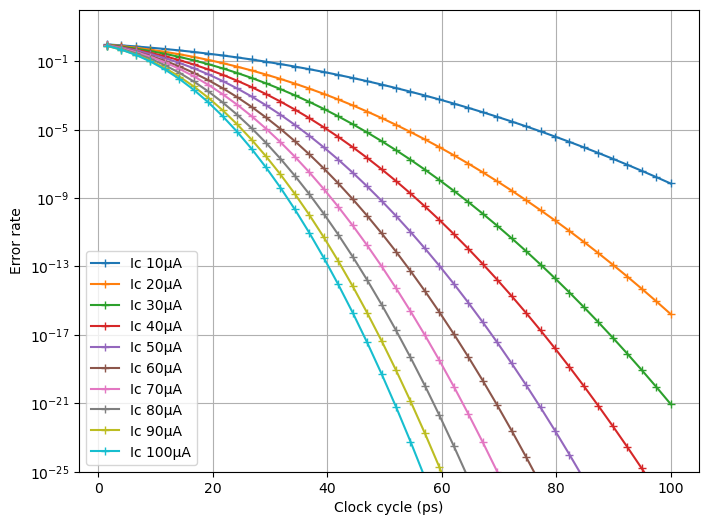

In [27]:
# (1)クロックサイクル時間、臨界電流値毎のエラー率の比較

# クロックサイクル時間の範囲の指定
t_values = np.linspace(1.5e-12, 1e-10, 40)
t_values_ps = [t*10**12 for t in t_values]


holds = pd.read_csv(hold_file,names=["LIc","Ic","mean","std"])
sets = pd.read_csv(setup_file,names=["LIc","Ic","mean","std"])
jitters = pd.read_csv(jitter_file,names=["LIc","Ic","std"])


LIc = 192.5
# Ics = [10,50,100]
Ics = [10,20,30,40,50,60,70,80,90,100]

plt.figure(figsize=(8, 6))
plt.rcParams['font.family'] = ''

for ic in Ics:
    # タイミングパラメータの取得
    setup_mean = sets[(sets["LIc"]==LIc) & (sets["Ic"]==ic)]["mean"].values[0]*10**-12
    setup_std = sets[(sets["LIc"]==LIc) & (sets["Ic"]==ic)]["std"].values[0]*10**-12
    hold_mean = holds[(holds["LIc"]==LIc) & (holds["Ic"]==ic)]["mean"].values[0]*10**-12
    hold_std = holds[(holds["LIc"]==LIc) & (holds["Ic"]==ic)]["std"].values[0]*10**-12
    jitter = jitters[(jitters["LIc"]==LIc) & (jitters["Ic"]==ic)]["std"].values[0]

    # 揺らぎの合計の計算
    ## 揺らぎが生じるSQUIDの個数を指定
    squid_count = 10+10 #50
    # total = calc_total(hold_std,setup_std,jitter,squid_count)
    total = calc_total_mp(hold_std,setup_std,jitter,squid_count)

    # エラー率の計算
    error_values = [calc_error_mp(t,setup_mean,hold_mean,total) for t in t_values]

    # グラフのプロット
    plt.plot(t_values_ps, error_values,marker='+', label='Ic '+str(ic)+'μA')

# plt.axhline(y=1e-12, color='black', linestyle='--')
plt.yscale('log')
plt.ylim(1e-25, 1e2)
plt.xlabel('Clock cycle (ps)')
plt.ylabel('Error rate')
plt.grid(True)
plt.legend()
plt.show()

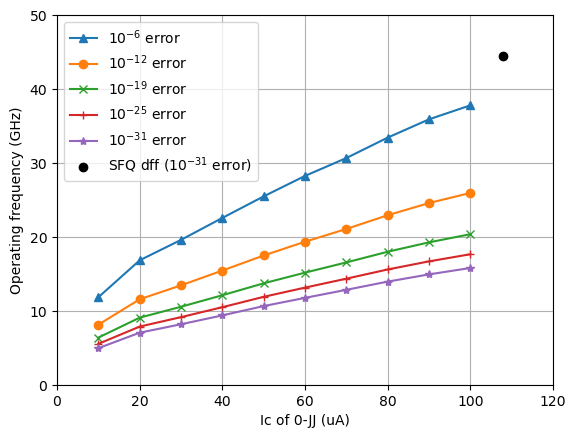

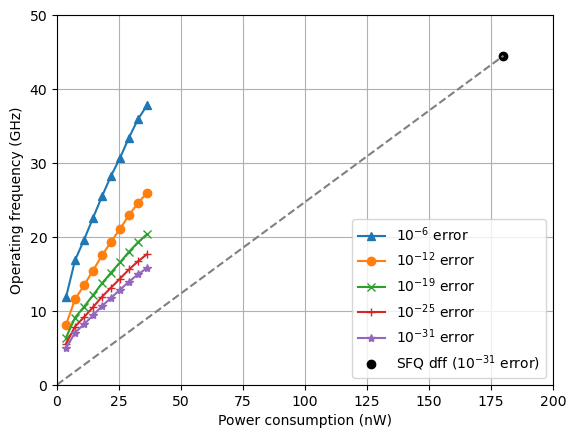

50 uA
25.4836693751058330598498235036371724660251586555072827083698231957334511100622996369595491497184745168879088959742056339287147819008125511836317894767448766570492306194887305366800079050698913109196741075551571113455662706659464418357509873524566580707165431056351958229831338824389782062898170501240431386293788701996129770489999819897501993536442455536861305439606113400699668498492968071993147066273769081603022666197106115996678245949695685911996274181168972300602971411925049360633706718990537584111262494585331698270007837467952661005929752343232069436400107497099831162535651666069892504238470465984325016774898066478479450904971205290724973423674460535451072420568937239945397765867440659679721170747374937436422892372179836498224015055951162431937335534464057492240596041784975009186786265309215997895213280035274892687807403783006319393808712516823671157137919130176621780782145474488203254729546360440061143802777517329099568016903856349476616636537373406616675888377087953224381803

In [28]:
# (4) 特定のエラー率の時の周波数、消費電力の比較

holds = pd.read_csv(hold_file,names=["LIc","Ic","mean","std"])
sets = pd.read_csv(setup_file,names=["LIc","Ic","mean","std"])
jitters = pd.read_csv(jitter_file,names=["LIc","Ic","std"])

# JTL部分を除いた、DFFのコア部分の消費電力ファイル
dff_core_power_file = "csv_files/power_dynamic.csv"
powers = pd.read_csv(dff_core_power_file,names=["Ic","LIc","power"])

# 比較する臨界電流値のリスト
ics = [ i for i in range(10, 110, 10)]

LIc = 192.5
error_list = []

time_list_extreme = []
time_list_loose = []
time_list_tight = []
time_list_axnpu = []
time_list_sfq = []
time_list_worst = []

for ic in ics:
    # タイミングパラメータの取得
    setup_mean = sets[(sets["LIc"]==LIc) & (sets["Ic"]==ic)]["mean"].values[0]*10**-12
    setup_std = sets[(sets["LIc"]==LIc) & (sets["Ic"]==ic)]["std"].values[0]*10**-12
    hold_mean = holds[(holds["LIc"]==LIc) & (holds["Ic"]==ic)]["mean"].values[0]*10**-12
    hold_std = holds[(holds["LIc"]==LIc) & (holds["Ic"]==ic)]["std"].values[0]*10**-12
    jitter = jitters[(jitters["LIc"]==LIc) & (jitters["Ic"]==ic)]["std"].values[0]

    # 揺らぎの合計の計算
    ## 揺らぎが生じるSQUIDの個数を指定
    squid_count = 20
    # total = calc_total(hold_std,setup_std,jitter,squid_count)
    total = calc_total_mp(hold_std,setup_std,jitter,squid_count)

    # 特定のエラー率に対するクロックサイクル時間の計算
    time_extreme = calc_t(1*10**-3,setup_mean,hold_mean,total)
    time_loose = calc_t(1*10**-6,setup_mean,hold_mean,total)
    time_axnpu = calc_t(1*10**-12,setup_mean,hold_mean,total)
    time_tight = calc_t(1*10**-19,setup_mean,hold_mean,total)
    time_sfq = calc_t(1*10**-25,setup_mean,hold_mean,total)
    time_worst = calc_t(1*10**-31,setup_mean,hold_mean,total)
    time_list_extreme.append(time_extreme)
    time_list_loose.append(time_loose)
    time_list_axnpu.append(time_axnpu)
    time_list_tight.append(time_tight)
    time_list_sfq.append(time_sfq)
    time_list_worst.append(time_worst)

# クロックサイクル時間を周波数に変換
freqs_extreme = [(1/t)*1e-9 for t in time_list_extreme]
freqs_loose = [(1/t)*1e-9 for t in time_list_loose]
freqs_axnpu = [(1/t)*1e-9 for t in time_list_axnpu]
freqs_tight = [(1/t)*1e-9 for t in time_list_tight]
freqs_sfq = [(1/t)*1e-9 for t in time_list_sfq]
freqs_worst = [(1/t)*1e-9 for t in time_list_worst]
    
# クロックサイクル数を掛けて、1秒あたりのエネルギー(消費電力)に変換
power_w = powers[powers["LIc"]==LIc]["power"].values*10**9
power_nW = [p*10**9 for p in power_w]

# 臨界電流地と周波数のグラフのプロット
plt.rcParams['font.family'] = ''
# plt.plot(ics, freqs_extreme, marker='s', label=r'$10^{-3}$ error')
plt.plot(ics, freqs_loose, marker='^', label=r'$10^{-6}$ error')
plt.plot(ics, freqs_axnpu, marker='o', label=r'$10^{-12}$ error')
plt.plot(ics, freqs_tight, marker='x', label=r'$10^{-19}$ error')
plt.plot(ics, freqs_sfq, marker='+', label=r'$10^{-25}$ error')
plt.plot(ics, freqs_worst, marker='*', label=r'$10^{-31}$ error')
plt.scatter(108, 44.5, color='black', label=r'SFQ dff ($10^{-31}$ error)')
# plt.plot([0, 108], [0, 50], linestyle='--', color='gray')
plt.xlabel('Ic of 0-JJ (uA)')
plt.ylabel('Operating frequency (GHz)')
plt.ylim(0, 50)
plt.xlim(0, 120)
plt.grid(True)
plt.legend() 
plt.show()

# 消費電力と周波数のグラフのプロット
# plt.plot(power_nW, freqs_extreme, marker='s', label=r'$10^{-3}$ error')
plt.plot(power_nW, freqs_loose, marker='^', label=r'$10^{-6}$ error')
plt.plot(power_nW, freqs_axnpu, marker='o', label=r'$10^{-12}$ error')
plt.plot(power_nW, freqs_tight, marker='x', label=r'$10^{-19}$ error')
plt.plot(power_nW, freqs_sfq, marker='+', label=r'$10^{-25}$ error')
plt.plot(power_nW, freqs_worst, marker='*', label=r'$10^{-31}$ error')
plt.scatter(1800*0.2*0.5, 44.5, color='black', label=r'SFQ dff ($10^{-31}$ error)')
plt.plot([0, 1800*0.2*0.5], [0, 44.5], linestyle='--', color='gray')
plt.xlabel('Power consumption (nW)')
plt.ylabel('Operating frequency (GHz)')
plt.ylim(0, 50)
plt.xlim(0, 200)
plt.grid(True)
plt.legend()
plt.show()

print(ics[4], 'uA')
print(freqs_loose[4], 'GHz')
print(freqs_worst[4], 'GHz')
print(power_nW[4], 'nW')
print(power_nW[4]/0.5, 'uA')
print()
print(ics[0], 'uA')
print(freqs_loose[0], 'GHz')
print(freqs_worst[0], 'GHz')
print(power_nW[0], 'nW')
print(power_nW[0]/0.5, 'uA')


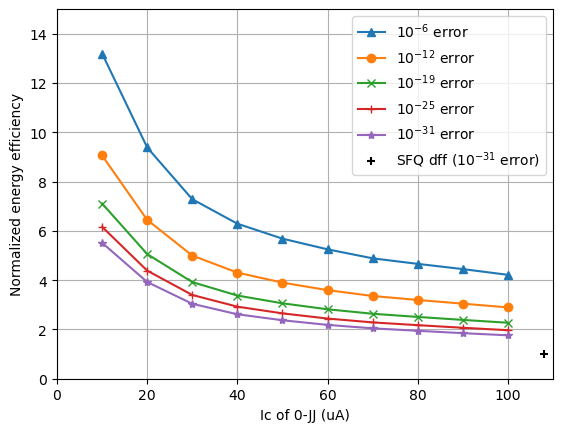

In [29]:
gops_extreme = [f/p for p,f in zip(power_nW, freqs_extreme)]
gops_loose = [f/p for p,f in zip(power_nW, freqs_loose)]
gops_axnpu = [f/p for p,f in zip(power_nW, freqs_axnpu)]
gops_tight = [f/p for p,f in zip(power_nW, freqs_tight)]
gops_sfq = [f/p for p,f in zip(power_nW, freqs_sfq)]
gops_worst = [f/p for p,f in zip(power_nW, freqs_worst)]
gops_sfq_dff = 44.5/(1800*0.2*0.5)

# baseline = gops_tight[6]
# baseline = gops_sfq[6]
# baseline = gops_worst[4]
baseline = gops_sfq_dff

gops_extreme = [g/baseline for g in gops_extreme]
gops_loose = [g/baseline for g in gops_loose]
gops_axnpu = [g/baseline for g in gops_axnpu]
gops_tight = [g/baseline for g in gops_tight]
gops_sfq = [g/baseline for g in gops_sfq]
gops_worst = [g/baseline for g in gops_worst]
gops_sfq_dff = gops_sfq_dff/baseline

fig = plt.figure()
# plt.plot(ics, gops_extreme, marker='s', label=r'$10^{-3}$ error')
plt.plot(ics, gops_loose, marker='^', label=r'$10^{-6}$ error')
plt.plot(ics, gops_axnpu, marker='o', label=r'$10^{-12}$ error')
plt.plot(ics, gops_tight, marker='x', label=r'$10^{-19}$ error')
plt.plot(ics, gops_sfq, marker='+', label=r'$10^{-25}$ error')
plt.plot(ics, gops_worst, marker='*', label=r'$10^{-31}$ error')
plt.scatter(108, gops_sfq_dff, color='black', marker='+', label=r'SFQ dff ($10^{-31}$ error)')
plt.xlabel('Ic of 0-JJ (uA)')
plt.ylabel('Normalized energy efficiency')
plt.xlim(0, 110)
# plt.ylim(0, 20)
plt.ylim(0, 15)
plt.legend()
plt.grid()
plt.show()

In [30]:
# Vb = 2.5mV, JTL Ic = 216uA
sfq_xor_error = calc_error_mp(20e-12, 3.7e-12, 4.1e-12, calc_total_mp(0.11e-12, 0.18e-12, 0.1e-12, 20))
print(float(sfq_xor_error))
print(mp_to_float_exact(sfq_xor_error))
sfq_dff_error = calc_error_mp(20e-12, 1.2e-12, -0.9e-12, calc_total_mp(0.12e-12, 0.11e-12, 0.1e-12, 20))
print(float(sfq_dff_error))
print(mp_to_float_exact(sfq_dff_error))

5.763773589281243e-35
35
3.7053978161794285e-95
95


In [31]:
# Vb = 1.25mV, JTL Ic = 216uA
sfq_xor_error = calc_error_mp(20e-12, 4.8e-12, 4.8e-12, calc_total_mp(0.13e-12, 0.19e-12, 0.12e-12, 20))
print(float(sfq_xor_error))
print(mp_to_float_exact(sfq_xor_error))

5.346277141176956e-19
19


In [32]:
# Vb = 0.5mV, JTL Ic = 216uA
sfq_xor_error = calc_error_mp(20e-12, 5.5e-12, 5.5e-12, calc_total_mp(0.2e-12, 0.21e-12, 0.15e-12, 20))
print(float(sfq_xor_error))
print(mp_to_float_exact(sfq_xor_error))
sfq_dff_error = calc_error_mp(20e-12, 2.0e-12, -1.7e-12, calc_total_mp(0.27e-12, 0.3e-12, 1.5*0.1e-12, 20))
print(float(sfq_dff_error))
print(mp_to_float_exact(sfq_dff_error))

7.392338281812045e-10
10
2.660336719041779e-36
36


In [33]:
# Vb = 0.5mV, JTL Ic = 216uA
sfq_xor_error = calc_error_mp(21.4e-12, 5.5e-12, 5.5e-12, calc_total_mp(0.2e-12, 0.21e-12, 1.5*0.1e-12, 20))
print(float(sfq_xor_error))
print(mp_to_float_exact(sfq_xor_error))
sfq_dff_error = calc_error_mp(21.4e-12, 2.0e-12, -1.7e-12, calc_total_mp(0.27e-12, 0.3e-12, 1.5*0.1e-12, 20))
print(float(sfq_dff_error))
print(mp_to_float_exact(sfq_dff_error))

1.1168507397792958e-12
12
2.1683711793550133e-41
41


In [34]:
# Vb = 0.5mV, JTL Ic = 216uA
sfq_xor_error = calc_error_mp(19.23e-12, 5.5e-12, 5.5e-12, calc_total_mp(0.2e-12, 0.21e-12, 1.5*0.1e-12, 20))
print(float(sfq_xor_error))
print(mp_to_float_exact(sfq_xor_error))
sfq_dff_error = calc_error_mp(19.23e-12, 2.0e-12, -1.7e-12, calc_total_mp(0.27e-12, 0.3e-12, 1.5*0.1e-12, 20))
print(float(sfq_dff_error))
print(mp_to_float_exact(sfq_dff_error))

1.7953147980518027e-08
8
1.1930666222750839e-33
33


In [35]:
# Vb = 0.5mV, JTL Ic = 108uA
sfq_xor_error = calc_error_mp(20e-12, 5.5e-12, 5.5e-12, calc_total_mp(1.2*0.2e-12, 1.2*0.21e-12, 1.2*1.5*0.1e-12, 20))
print(float(sfq_xor_error))
print(mp_to_float_exact(sfq_xor_error))
sfq_dff_error = calc_error_mp(20e-12, 2.0e-12, -1.7e-12, calc_total_mp(1.2*0.27e-12, 1.2*0.3e-12, 1.2*1.5*0.1e-12, 20))
print(float(sfq_dff_error))
print(mp_to_float_exact(sfq_dff_error))

2.878820736384212e-07
7
1.0145949617482123e-25
25


In [36]:
# Vb = 0.5mV, JTL Ic = 108uA
sfq_xor_error = calc_error_mp(22.3e-12, 5.5e-12, 5.5e-12, calc_total_mp(1.2*0.2e-12, 1.2*0.21e-12, 1.2*1.5*0.1e-12, 20))
print(float(sfq_xor_error))
print(mp_to_float_exact(sfq_xor_error))
sfq_dff_error = calc_error_mp(22.3e-12, 2.0e-12, -1.7e-12, calc_total_mp(1.2*0.27e-12, 1.2*0.3e-12, 1.2*1.5*0.1e-12, 20))
print(float(sfq_dff_error))
print(mp_to_float_exact(sfq_dff_error))

1.1750429578424403e-10
10
1.1473938050263837e-31
31


In [37]:
# Vb = 0.5mV, JTL Ic = 108uA
sfq_xor_error = calc_error_mp(23.5e-12, 5.5e-12, 5.5e-12, calc_total_mp(1.2*0.2e-12, 1.2*0.21e-12, 1.2*1.5*0.1e-12, 20))
print(float(sfq_xor_error))
print(mp_to_float_exact(sfq_xor_error))
sfq_dff_error = calc_error_mp(23.5e-12, 2.0e-12, -1.7e-12, calc_total_mp(1.2*0.27e-12, 1.2*0.3e-12, 1.2*1.5*0.1e-12, 20))
print(float(sfq_dff_error))
print(mp_to_float_exact(sfq_dff_error))

1.0281601267053445e-12
12
5.019731738535239e-35
35
